In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re, sys

# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# keras stuff
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

%matplotlib inline

Using Theano backend.


In [64]:
def delete_relevant(folder):
    if folder[-1] != '/':
        folder += '/'
    files = os.listdir(folder)
    for f in files:
        if re.match(r'u[0-9]+_w[0-9]+_(accelerometer|gyroscope)\.log', f) == None:
            print('deleting %s' % f)
            os.remove(folder + f)

In [65]:
base = './Data/'
for d in os.listdir(base):
    if os.path.isdir(base + d):
        delete_relevant(base + d)

deleting u001_w001_gravity.log
deleting u001_w001_linearaccelerometer.log
deleting u001_w001_magnetometer.log
deleting u001_w001_rotvec.log
deleting u001_w002_gravity.log
deleting u001_w002_linearaccelerometer.log
deleting u001_w002_magnetometer.log
deleting u001_w002_rotvec.log
deleting u001_w003_gravity.log
deleting u001_w003_linearaccelerometer.log
deleting u001_w003_magnetometer.log
deleting u001_w003_rotvec.log
deleting u002_w001_gravity.log
deleting u002_w001_linearaccelerometer.log
deleting u002_w001_magnetometer.log
deleting u002_w001_rotvec.log
deleting u002_w002_gravity.log
deleting u002_w002_linearaccelerometer.log
deleting u002_w002_magnetometer.log
deleting u002_w002_rotvec.log
deleting u002_w003_gravity.log
deleting u002_w003_linearaccelerometer.log
deleting u002_w003_magnetometer.log
deleting u002_w003_rotvec.log
deleting u002_w004_gravity.log
deleting u002_w004_linearaccelerometer.log
deleting u002_w004_magnetometer.log
deleting u002_w004_rotvec.log
deleting u003_w001_g

In [66]:
u_dict = {}
files = [x for x in os.listdir(base) if os.path.isdir(base+x)]
for f in files:
    uid, trial = re.findall(r'u([0-9]+)_w([0-9]+)', f)[0]
    uid, trial = int(uid), int(trial)
    if uid not in u_dict:
        u_dict[uid] = [trial]
    else:
        u_dict[uid].append(trial)

In [67]:
def gen_fname(uid, trial):
    f = lambda x: ('%3d' % x).replace(' ', '0')
    return 'u%s_w%s' % (f(uid), f(trial))

In [89]:
def get_data(uid, trial):
    fname = gen_fname(uid, trial)
    d1 = pd.read_csv('./Data/%s/%s_accelerometer.log' % (fname, fname), delimiter='\t')
#     d2 = pd.read_csv('./Data/%s/%s_gyroscope.log' % (fname, fname), delimiter='\t')
#     return d1.join(d2)
    return d1

# Steps to extract cycles

1. discard the first 500 readings (assume sampling rate of 50Hz)
2. discard readings until first local minimum
3. assume template size of 150 readings

In [320]:
def corr(x1, x2):
    n = len(x1)
    return (x1.dot(x2) - n * x1.mean() * x2.mean())/(n * x1.std() * x2.std())

In [331]:
def find_cycles(data, viz=False):
    step = 150
    slack = 20
    threshold = 0.5
    counter = 0
    
    N = len(data)
    start_idx = np.argmin(data[:step])
    end_idx = start_idx+step-slack + np.argmin(data[start_idx+step-slack:start_idx+step+slack])

    R1 = data[np.arange(start_idx, end_idx)]
    L = end_idx - start_idx
    
    c = []
    for i in range(N-L):
        Di = data[i:i+L]
        ci = corr(R1, Di)
        c.append(ci)
    
    if viz:
        plt.figure(figsize=(15,4))
        plt.title('Correlation')
        plt.plot(c)
    
    starts = []
    for i in range(1, N-L-1):
        if c[i] > c[i-1] and c[i] > c[i+1] and c[i] > threshold:
            starts.append(i)
    
    return starts

In [332]:
def extract_feats(data, starts):
    ns = len(starts)
    out = []
    for i in range(ns-1):
        out.append(data[starts[i]:starts[i+1]])
    return out

In [333]:
def plot_steps(data, starts):
    plt.figure(figsize=(15,4))
    plt.plot(samples2)
    plt.title('Accelerometer Magnitude')
    plt.xlabel('$s$')
    plt.ylabel('$m/s^2$')
    mx = data.max()
    mn = data.min()
    vy = np.linspace(mn, mx, 2)

    for s in starts:
        vx = [s for _ in vy]
        plt.plot(vx, vy, c='r', linewidth=2)
    plt.show()
    
    plt.figure(figsize=(15,4))
    plt.title('Individual Walking Cycles')
    for s in extract_feats(data, starts):
        plt.plot(s)

In [334]:
def filter_datapoints(data):
    lengths = [len(x) for x in data]
    mean_len = np.mean(lengths)
    threshold = 0.25
    return [x for x in data if len(x) <= (1 + threshold) * mean_len and len(x) > (1 - threshold) * mean_len]

In [318]:
a = get_data(18, 2)
data = a.ix[:, 1:].values
n, d = data.shape
samples = np.zeros(n)
for d in data.T:
    samples += d ** 2
samples = samples ** 0.5

In [319]:
samples2 = samples[500:2000]

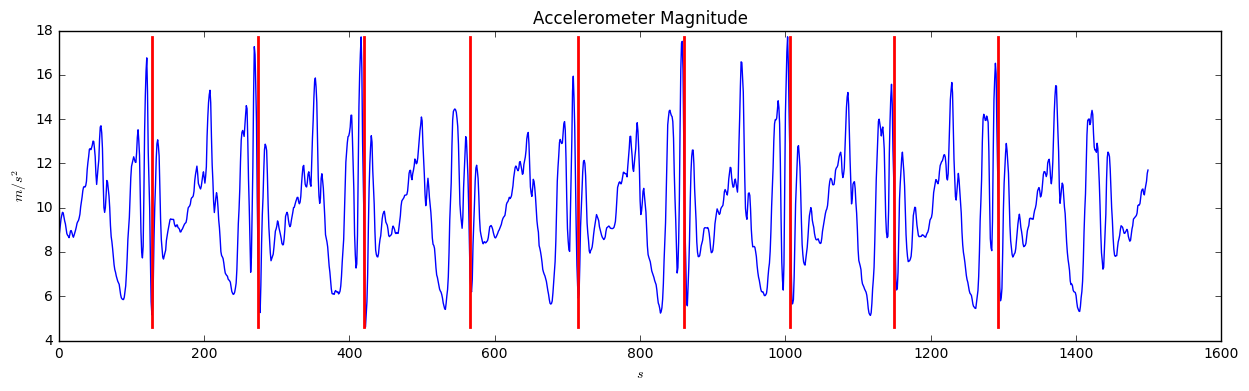

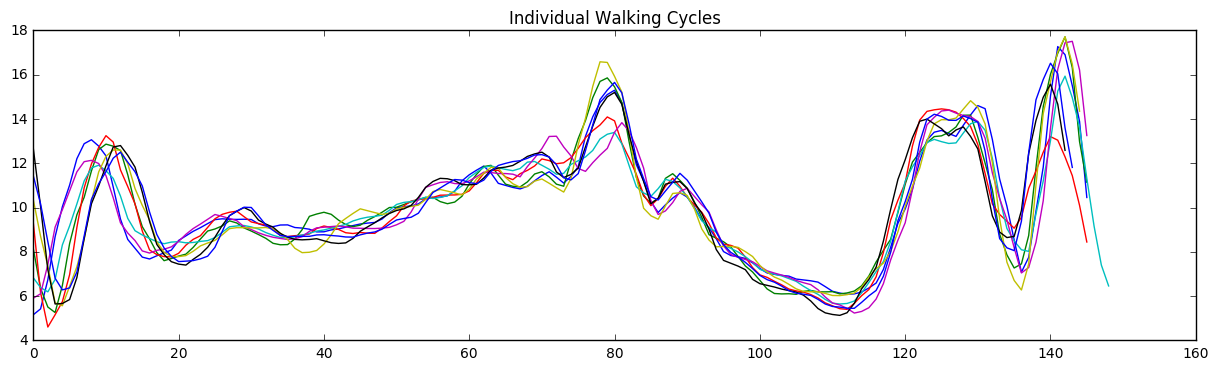

In [337]:
starts = find_cycles(samples2)
plot_steps(samples2, starts)